In [20]:
import localcider
from localcider.sequenceParameters import SequenceParameters
from Bio import SeqIO
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
import pandas as pd
import itertools
from sklearn.manifold import TSNE
import seaborn as sns
import re
import scipy.special as sps
from scipy.stats import ttest_ind

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
# rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['font.size']=15
plt.rcParams['pdf.fonttype']=42
plt.rcParams["text.usetex"]=False

# Stitching together IDRs from the different proteins and getting a list of IDRs with their Uniprot ID, strating position, and ending position

In [3]:
class IDR:
    """Class for keeping track of starting and ending positions of an IDR"""
    
    def __init__(self, start, end):
        self.start = start
        self.end = end
        
    def check_and_extend(self, idr_obj):
        # Check if the self sequence is a subset of the supplied idr
        if idr_obj.start <= self.start and idr_obj.end >= self.end:
            # If yes, change the start and end of the self sequence to the start and end of the supplied idr
            self.start = idr_obj.start
            self.end = idr_obj.end
            return True
        # Check if the end of the supplied sequence lies between the start and end of the self sequence
        elif idr_obj.end > self.start  and idr_obj.end <= self.end:
            # If yes, then there is overlap. Update the start of self sequence appropriately
            self.start = np.min([idr_obj.start, self.start])
            return True
        # Check if the start of the supplied sequence lies between the start and end of the self sequence
        elif idr_obj.start >= self.start and idr_obj.start < self.end:
            # If yes, then there is overlap. Update the end of self sequence appropriately
            self.end = np.max([idr_obj.end, self.end])
            return True
        # This is a completely new IDR
        else:
            return False
        
    def check_and_exclude(self, pfam_start, pfam_end):
        # Check if the self sequence is a subset of the supplied pfam domain
        if pfam_start <= self.start and pfam_end >= self.end:
            # If yes, remove this domain
            return (True, True, None)
        # Check if the the pfam domain is contained within the self sequence
        elif pfam_start > self.start and pfam_end < self.end:
            # If yes, then there is overlap. Update the start of self sequence appropriately
            new_idr = IDR(start=pfam_end, end=self.end)
            self.end = pfam_start
            return (False, True, new_idr)
        # Check if the start of the pfam domain lies between the start and end of the self sequence
        elif pfam_start >= self.start and pfam_start <= self.end:
            # If yes, then there is overlap. Update the end of self sequence appropriately
            self.end = pfam_start
            return (False, True, None)
        # Check if the end of the pfam domain lies between the start and end of the self sequence
        elif pfam_end >= self.start and pfam_end <= self.end:
            self.start = pfam_end
            return (False, True, None)
        # No overlap of the pfam domain with the idr whatsoever
        else:
            return (False, False, None)

In [18]:
def get_disordered_sequences(filename):
    """Function to read a file that is the output of InterProScan, construct a list of disordered domains predicted 
    by MobiDBLite by stitching together all predictions, and excluding regions that overlap with pfam domains """
    
    df = pd.read_csv(filename, delimiter='\t', 
                     names=['id', 'analysis', 'start', 'end'] , 
                     header=None, usecols=[0, 3, 6, 7])
    
    idr_dict = {}
    
    for protein in df['id'].unique():
        
        # Step 1: Get the start and end positions of the unique IDRs by stitching together sequences
        # ------------------------------------------------------------------------------------------
        
        # Select the row indices in the file that correspond to predictions of disordered sequences
        selected_idr_row_indices = df.index[(df['id']==protein)*(df['analysis']=='MobiDBLite')]
        
        # Check if this protein has at least one disorder prediction
        if len(selected_idr_row_indices) > 0: 
            
            idr_start_end_list = []
            # Initialize a list that will store the IDR class objects containing
            # start and end positions of IDRs of this protein
            
            # Store the raw list of idr start and end positions
            for index in selected_idr_row_indices:
                current_idr_obj = IDR(start=df.iloc[index]['start'], end=df.iloc[index]['end'])
                idr_start_end_list.append(current_idr_obj)
            
            # Stich together all the IDRs in the idr_start_end_list
            stitching_flag = True
            while stitching_flag:
                # Nothing to stitch if there is only one idr
                if len(idr_start_end_list) == 1:
                    break
                # If there are many idrs, compare every pair in the idr_start_end_list and check for overlap or subset
                for idr1, idr2 in itertools.combinations(idr_start_end_list, r=2):
                    stitching_flag = idr1.check_and_extend(idr2)
                    # If there is overlap or subset, remove the current idr_object[j], then restart the loops again
                    if stitching_flag:
                        idr_start_end_list.remove(idr2)
                        break 
            
            # Step 2: Exclude the idrs that overlap with pfam domains
            # -------------------------------------------------------
            
            # Select row indices that corresponds to pfam domain predictions
            selected_pfam_row_indices = df.index[(df['id']==protein)*(df['analysis']!='MobiDBLite')]
            
            # Exclude the idrs that overlap with pfam domains
            if len(selected_pfam_row_indices) > 0:             
                for index in selected_pfam_row_indices:
                    for idr in idr_start_end_list:
                        is_exclude, is_overlap, new_idr = idr.check_and_exclude(pfam_start=df.iloc[index]['start'],
                                                                                pfam_end=df.iloc[index]['end'])
                        if is_exclude:
                            # print("IDR removed because it is contained in a Pfam domain:", str(protein), 
                            #       '[', str(idr.start), '-', str(idr.end), ']')
                            idr_start_end_list.remove(idr)
                            break
                        else:
                            if new_idr is not None:
                                idr_start_end_list.append(new_idr)
                                # print("IDR broken into two because of overlap with Pfam domain:", 
                                #       str(protein), '[', str(idr.start), '-', str(idr.end), ']',
                                #       '[', str(new_idr.start), '-', str(new_idr.end), ']')
                            if is_overlap:
                                break
                            
            # print('IDR list after stitching and excluding:')
            # print(str(protein))
            # print([str(idr.start) + '-' + str(idr.end) for idr in idr_start_end_list])
            
            # Step 3: Exclude IDRs that are smaller than 30 amino acids long
            idr_dict[protein] = []
            # The final list of start-end positions of IDRs
            for idr in idr_start_end_list:
                if idr.end - idr.start < 40:
                    continue
                    # print("IDR removed because of small size:", str(protein), 
                    #      '[', str(idr.start), '-', str(idr.end), ']')
                else:
                    idr_dict[protein].append(idr) 
            # print('------------------------------------------')
    
    return idr_dict

In [14]:
def analyze_files(fasta_file_list, iprscan_file_list, names):
    """Function to analyze the charge distributions of sequences present in a list of files and display statistics"""
    
    assert len(fasta_file_list) == len(iprscan_file_list) and len(iprscan_file_list) == len(names), \
    "The lists need to be the same size"
    
    charge_features_dict_list = []
    
    for i in range(len(fasta_file_list)): 
        
        # Get the list of stitched and filtered idr start and end positions from the iprscan file
        idr_dict = get_disordered_sequences(iprscan_file_list[i])
        
        # Get the list of protein sequences from the fasta file
        protein_sequences = SeqIO.parse(fasta_file_list[i], 'fasta')
        
        charge_features_dict = {'ID': [], 'start_end': [], 'net_charge_per_residue': [], 'net_charge': [],
                                'total_positive': [], 'fraction_positive': [], 
                                'total_negative': [], 'fraction_negative': [], 'kappa': []}
        
        for sequence in protein_sequences:
            if sequence.id in idr_dict.keys():
                for idr in idr_dict[sequence.id]:
                    # Extract the IDR sequence by crossreferencing start and end positions in idr_dict with the 
                    # sequences in protein_sequences
                    if str(sequence.seq[idr.start:idr.end]) != "":
                        # print("--", str(sequence.seq[idr.start:idr.end]), "--")
                        obj = SequenceParameters(str(sequence.seq[idr.start:idr.end]))
                        # Net charge per residue of the sequence
                        charge_features_dict['net_charge_per_residue'].append(obj.get_NCPR(pH=7.2)) 
                        # Using a typical pH value of 7.2 of the nucleus, and assuming that this corresponds to the nucleolus
                        # Net total charge of the sequence
                        charge_features_dict['net_charge'].append(obj.get_NCPR(pH=7.2)*(idr.end-idr.start)) 
                        # charge_features_dict['net_charge'].append(obj.get_mean_net_charge(pH=7.2)) 
                        # Fraction of positive charges
                        charge_features_dict['fraction_positive'].append(obj.get_fraction_positive())
                        # Total positive charge of the sequence
                        charge_features_dict['total_positive'].append(obj.get_fraction_positive()*(idr.end-idr.start))
                        # Fraction of negative charges
                        charge_features_dict['fraction_negative'].append(obj.get_fraction_negative())
                        # Total negative charge of the sequence
                        charge_features_dict['total_negative'].append(obj.get_fraction_negative()*(idr.end-idr.start))
                        # Charge blockiness
                        # charge_features_dict['kappa'].append(obj.get_kappa())
                        charge_features_dict['kappa'].append(0.0)
                        # Sequence ID 
                        charge_features_dict['ID'].append(str(sequence.id))
                        # Start and end positions
                        charge_features_dict['start_end'].append((idr.start, idr.end))                  
                    
        # Store this list of charge features
        charge_features_dict_list.append(charge_features_dict)
        
        # Print the number of IDR sequences obtained
        print('Number of IDRs from ' + str(iprscan_file_list[i]) + ' : ', len(charge_features_dict['ID']))
    
    # Exclude the IDRs from the second list of files that overlap with the first list of files. 
    # We are assuming here that the second list of IDRs contains some overlap with the first. 
    charge_features_dict_dropped = {'ID': [], 'start_end': [], 'net_charge_per_residue': [], 'net_charge': [],
                                    'total_positive': [], 'fraction_positive': [], 
                                    'total_negative': [], 'fraction_negative': [], 'kappa': []}
    for i in range(len(charge_features_dict_list[1]['ID'])):
        if charge_features_dict_list[1]['ID'][i] not in charge_features_dict_list[0]['ID']:
            for key in charge_features_dict_list[1].keys():
                charge_features_dict_dropped[key].append(charge_features_dict_list[1][key][i])
    
    charge_features_dict_list[1] = charge_features_dict_dropped
    
    # Plot distributions of the charge sequence parameters of these proteins
    fig, axs = plt.subplots(7, 2, figsize=(6, 20))
    keys = ['net_charge_per_residue', 'net_charge', 'fraction_positive', 'total_positive',
            'fraction_negative', 'total_negative', 'kappa']
    titles = ['Net charge per residue', 'Net charge', 'Fraction positive', 'Positive charge',
            'Fraction negative', 'Negative charge', 'Kappa']
    for i in range(len(names)):
        # Plot the distributions of the charge features
        for j in range(len(keys)): 
            # axs[j,0].hist(charge_features_dict_list[i][keys[j]], cumulative=True, 
            #               density=True, histtype='step', bins=100, label=names[i])
            # axs[j,1].hist(charge_features_dict_list[i][keys[j]], density=True, 
            #               histtype='step', bins=25, label=names[i])
            sns.kdeplot(data=charge_features_dict_list[i][keys[j]], fill=True, cumulative=True,
                        ax=axs[j,0], label=names[i]).set(xlim=(np.min(charge_features_dict_list[i][keys[j]]),
                                                               np.max(charge_features_dict_list[i][keys[j]])))
            sns.kdeplot(data=charge_features_dict_list[i][keys[j]], fill=True, ax=axs[j,1], 
                        label=names[i]).set(xlim=(np.min(charge_features_dict_list[i][keys[j]]),
                np.max(charge_features_dict_list[i][keys[j]])))
            print('Average ', titles[j], 'in', names[i], ':', np.mean(charge_features_dict_list[i][keys[j]]))
    for i in range(len(keys)):
        # axs[i,0].legend()
        axs[i,0].set_xlabel(titles[i])
        axs[i,0].set_ylabel('Cumulative density')
        axs[i,1].legend()
        axs[i,1].set_xlabel(titles[i])
        axs[i,1].set_ylabel('Probability density')
    fig.tight_layout()
    plt.show()
    plt.close()
    
    return charge_features_dict_list

In [15]:
def visualize_tsne(fasta_file_list, iprscan_file_list, names):
    """Function to generate a data matrix of all the sequences using their amino acid compositions and then 
    visualize this data matrix using a t-SNE plot, with labels colored by where the protein is present"""
    
    assert len(fasta_file_list) == len(iprscan_file_list) and len(iprscan_file_list) == len(names), \
    "The lists need to be the same size"
    
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    amino_acid_grps = [['A'], ['C'], ['D'], ['E'], ['F'], ['G'], ['H'], ['I'], ['K'], 
                       ['L'], ['M'], ['N'], ['P'], ['Q'], ['R'], ['S'], ['T'], ['V'], ['W'], ['Y']]
#     amino_acids = ['D', 'E', 'K', 'R']
#     amino_acid_grps = [['D', 'E'], ['K', 'R']]
#     amino_acid_grp_names = ['Negative', 'Positive']

    composition_data_matrix = []
    IDR_name_list = []
    IDR_id_list = []
    labels = []
    
    for i in range(len(fasta_file_list)): 
        # Get the list of stitched and filtered idr start and end positions from the iprscan file
        idr_dict = get_disordered_sequences(iprscan_file_list[i])
        # Get the list of protein sequences from the fasta file
        protein_sequences = SeqIO.parse(fasta_file_list[i], 'fasta')
        for sequence in protein_sequences:
            # Exclude sequences that were already present in the previous file
            if sequence.id in idr_dict.keys() and sequence.id not in IDR_id_list:
                IDR_id_list.append(sequence.id)
                for idr in idr_dict[sequence.id]:
                    # Extract the IDR sequence by crossreferencing start and end positions in idr_dict with the 
                    # sequences in protein_sequences
                    obj = SequenceParameters(str(sequence.seq[idr.start:idr.end]))
                    # Get sequence composition
                    _, composition_matrix = obj.get_linear_sequence_composition(blobLen=1, grps=amino_acid_grps)
                    composition_vector = np.sum(composition_matrix, axis=1)/(idr.end-idr.start)
                    composition_data_matrix.append(composition_vector)
                    IDR_name_list.append(str(sequence.id) + '_' + str(idr.start) + '_' + str(idr.end))
                    labels.append(i)
        # Print the number of IDR sequences obtained
        print('Number of IDRs from ' + str(iprscan_file_list[i]) + ' : ', len(IDR_name_list))
    
    # Construct data matrix
    data_matrix = pd.DataFrame(composition_data_matrix, columns=amino_acids)
    # data_matrix = pd.DataFrame(composition_data_matrix, columns=amino_acid_grp_names)
    data_matrix['ID'] = IDR_name_list
    data_matrix['label'] = labels
    
    return data_matrix

# Analysis of human nucleolar proteome

## Method 1: (Human Cell Atlas annotations)

Proteins were obtained from the human cell atlas: https://www.proteinatlas.org/search/subcell_location:Nucleoli

The queries used were: 
1. **For nucleolar proteins** subcell_location:Nucleoli AND hpa_evidence:Evidence at protein level
2. **For nucleolar FC proteins** subcell_location:Nucleoli fibrillar center AND hpa_evidence:Evidence at protein level

### IDRs of the proteins excluding domains from Pfam

In [ ]:
# Charge features of IDRs from Human Cell Atlas

charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Human_Protein_Atlas/Nucleolar_FC_protein_sequences.fasta',
                                           'Human_Protein_Atlas/Nucleolar_protein_sequences.fasta'],
                                          iprscan_file_list=
                                          ['Human_Protein_Atlas/Nucleolus_FC_iprscan_results.tsv', 
                                           'Human_Protein_Atlas/Nucleolus_iprscan_results.tsv'],
                                          names=['FC', 'Rest'])

keys = ['net_charge_per_residue', 'net_charge', 'fraction_positive', 'total_positive',
            'fraction_negative', 'total_negative', 'kappa']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)

In [ ]:
# t-SNE representation of the sequences

data_matrix = visualize_tsne(fasta_file_list=['Human_Protein_Atlas/Nucleolar_FC_protein_sequences.fasta',
                                              'Human_Protein_Atlas/Nucleolar_protein_sequences.fasta'],
                             iprscan_file_list=['Human_Protein_Atlas/Nucleolus_FC_iprscan_results.tsv', 
                                                'Human_Protein_Atlas/Nucleolus_iprscan_results.tsv'],
                             names=['FC', 'GC'])

features = data_matrix.iloc[:, 0:-2]
labels = data_matrix.iloc[:, -1]

# Initialize t-SNE with 2 components (for 2D visualization)
tsne = TSNE(n_components=2, random_state=42, perplexity=10)

# Fit and transform the data
tsne_projection = tsne.fit_transform(features)

# Create a new DataFrame for t-SNE projections
tsne_df = pd.DataFrame(data=tsne_projection, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = labels

# Plot t-SNE with color-coded labels
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_df, palette='coolwarm', legend='full', alpha=0.5)
plt.title('t-SNE Plot')
plt.show()

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


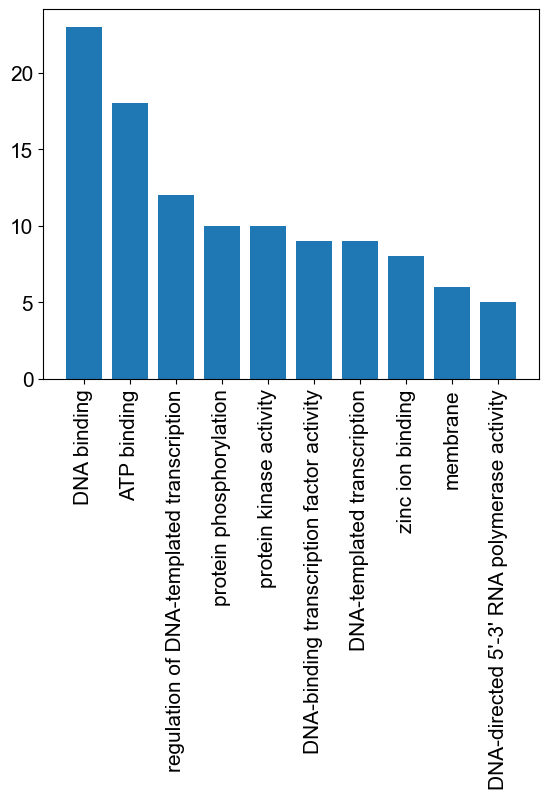

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


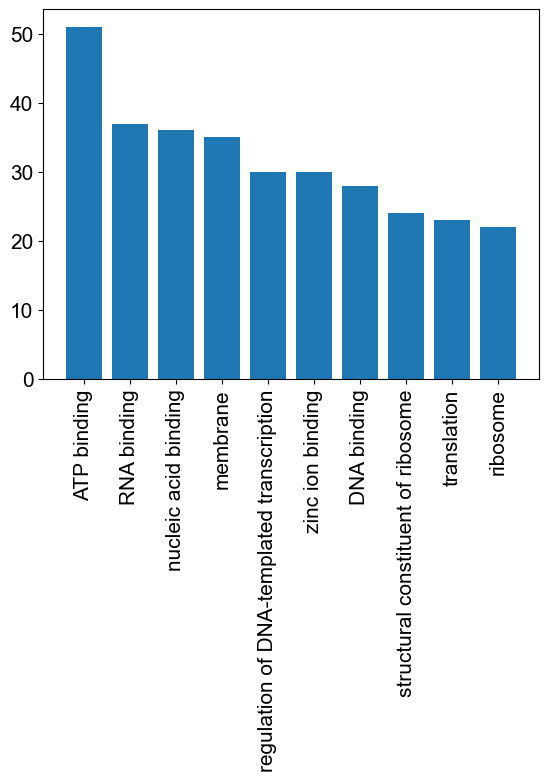

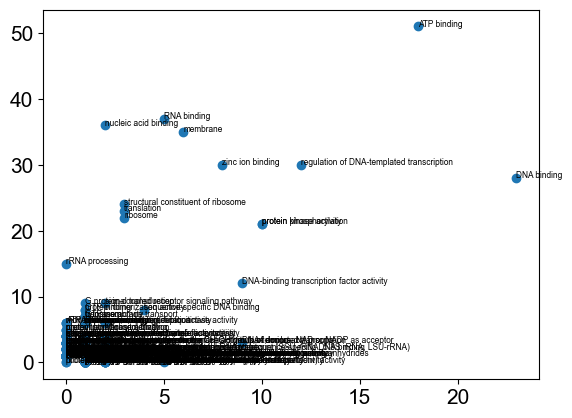

In [23]:
# Read each line of the files, get the GO terms, and compare for the two files

# filename = 'Uniprot_Human/FC_proteins_human.tsv'
filenames = ['Human_Protein_Atlas/HPA_mouse_FC.tsv',
             'Human_Protein_Atlas/HPA_mouse_nonFC.tsv']
file_types = ['FC', 'Rest']
df_list = []

# Read sequence ID and the corresponding GO terms from the tsv file
for file in filenames:
    df = pd.read_csv(file, delimiter='\t', names=['id', 'GO_terms'], header=None, usecols=[0, 13])
    # Drop those row entries where there are no GO annotations
    df = df[df['GO_terms'] != '-']
    # Remove all proteins that occurred in the previous datasets
    for df_previous in df_list:
        for protein in df['id'].unique():
            if protein in df_previous['id']:
                df = df[df['id']!=protein]
    df_list.append(df)
    
unique_GO_terms_list = []
# Get a histogram of the number of times a particular GO ID occurs in the dataset
for df in df_list:
    unique_GO_terms_list += [go for string in df['GO_terms'] for go in string.split('|')]

unique_GO_terms_list = [go_term.split('(')[0] for go_term in unique_GO_terms_list]
unique_GO_terms = set(unique_GO_terms_list)        
# print(unique_GO_terms)

go_names_list = []
go_id_list_sorted = []

# Read through the GO OBO file and assign names to the GO terms
store_next_line = 0
with open('go.obo', 'r') as f:
    pattern = re.compile('^id: GO:.*')
    for line in f:
        if store_next_line:
            # Read the name of the GO term
            go_names_list.append(line.rstrip()[6:])
            store_next_line = 0
        if pattern.match(line.rstrip()) and line.rstrip()[4:] in unique_GO_terms:
            go_id_list_sorted.append(line.rstrip()[4:])
            # The next line contains the name of the GO term
            store_next_line = 1
        
go_names_df = pd.DataFrame(data=np.array([go_id_list_sorted, go_names_list]).transpose(), columns=['go_id', 'go_name'])
# go_names_df.head(20)

# print(df_list[0].head(20))
# print(df_list[1].head(20))

for i in range(len(df_list)): # df in df_list:
    # Count the number of occurences of each GO term in each dataset
    go_names_df[file_types[i]] = np.zeros(len(go_names_list))
    # Dataframe to store counts of the different GO terms. Initialize this:
    # counts_df['go_term'] = list(unique_GO_terms)
    # counts_df['counts'] = np.zeros(len(unique_GO_terms))
    for protein in df_list[i]['id'].unique():
        go_terms_for_this_protein = [go for string in list(df_list[i][df_list[i]['id']==protein]['GO_terms']) 
                                     for go in string.split('|')]
        go_terms_for_this_protein = [go.split('(')[0] for go in go_terms_for_this_protein]
        for go_term in go_id_list_sorted:
            if go_term in go_terms_for_this_protein:
                go_names_df[file_types[i]][go_names_df['go_id']==go_term] += 1.0

    # print(np.sum(counts_df['counts']))
    go_names_df[file_types[i]][go_names_df['go_name'] == 'nucleus'] = 0
    go_names_df[file_types[i]][go_names_df['go_name'] == 'protein binding'] = 0
    go_names_df = go_names_df.sort_values(by=file_types[i], ascending=False)
    
    plt.bar(go_names_df['go_name'].iloc[0:10], go_names_df[file_types[i]].iloc[0:10])
    plt.xticks(rotation=90)
    plt.show()
    plt.close()
    
plt.scatter(go_names_df['FC'], go_names_df['Rest'])
for (x, y, name) in zip(go_names_df['FC'], go_names_df['Rest'], go_names_df['go_name']):
    plt.text(x, y, name, fontsize=6)
# plt.xlim([0.0, 0.18])
# plt.ylim([0.0, 0.18])
plt.show()
plt.close()

### IDRs of the proteins excluding domains from Pfam, CDD, Prosite

Number of IDRs from Human_Protein_Atlas/Nucleolus_FC_iprscan_results_additional_databases.tsv :  155
Number of IDRs from Human_Protein_Atlas/Nucleolus_iprscan_results_additional_databases.tsv :  474
Average  Net charge per residue in FC/DFC : -0.005974604849782584
Average  Net charge in FC/DFC : -1.0704080820259885
Average  Fraction positive in FC/DFC : 0.13654705646879273
Average  Positive charge in FC/DFC : 13.348387096774193
Average  Fraction negative in FC/DFC : 0.14628777013886557
Average  Negative charge in FC/DFC : 14.754838709677419
Average  Kappa in FC/DFC : 0.24127865095606005
Average  Net charge per residue in GC : -0.0026626809907961714
Average  Net charge in GC : -0.6621552168471763
Average  Fraction positive in GC : 0.15531428275841097
Average  Positive charge in GC : 13.455128205128204
Average  Fraction negative in GC : 0.16095903757854793
Average  Negative charge in GC : 14.378205128205128
Average  Kappa in GC : 0.27973887698381183


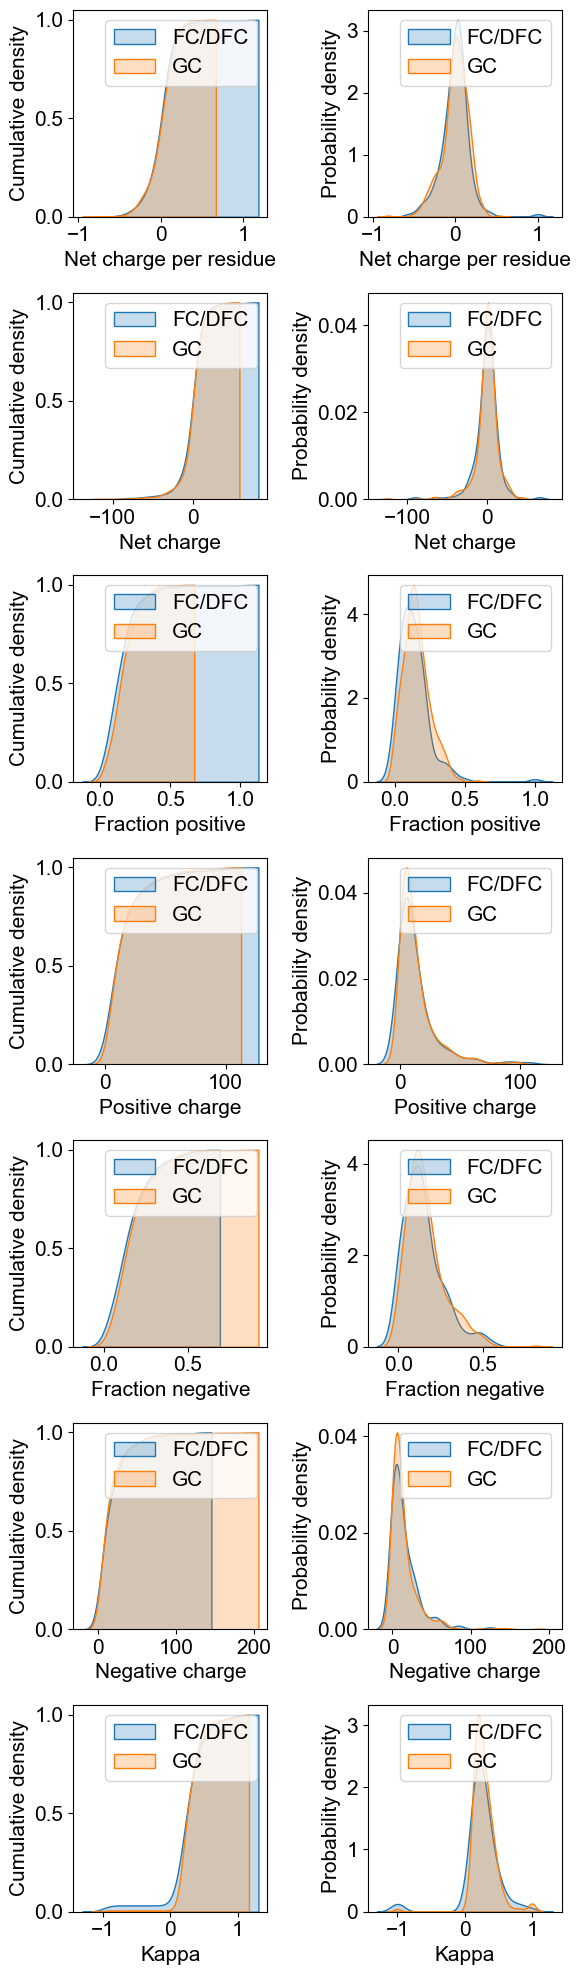

net_charge_per_residue :  KstestResult(statistic=0.10978770333609043, pvalue=0.11015227262904492)
net_charge :  KstestResult(statistic=0.05135097877033361, pvalue=0.8983510492215501)
fraction_positive :  KstestResult(statistic=0.15842293906810037, pvalue=0.005013239111846923)
total_positive :  KstestResult(statistic=0.057416597739178385, pvalue=0.8096477956791049)
fraction_negative :  KstestResult(statistic=0.10380479735318444, pvalue=0.14920820924035427)
total_negative :  KstestResult(statistic=0.0742211193824097, pvalue=0.5126716364911378)
kappa :  KstestResult(statistic=0.10002757099531293, pvalue=0.1792137186924141)


In [65]:
charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Human_Protein_Atlas/Nucleolar_FC_protein_sequences.fasta',
                                           'Human_Protein_Atlas/Nucleolar_protein_sequences.fasta'],
                                          iprscan_file_list=[ 
                                        'Human_Protein_Atlas/Nucleolus_FC_iprscan_results_additional_databases.tsv', 
                                        'Human_Protein_Atlas/Nucleolus_iprscan_results_additional_databases.tsv'],
                                          names=['FC/DFC', 'GC'])

keys = ['net_charge_per_residue', 'net_charge', 'fraction_positive', 'total_positive',
            'fraction_negative', 'total_negative', 'kappa']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


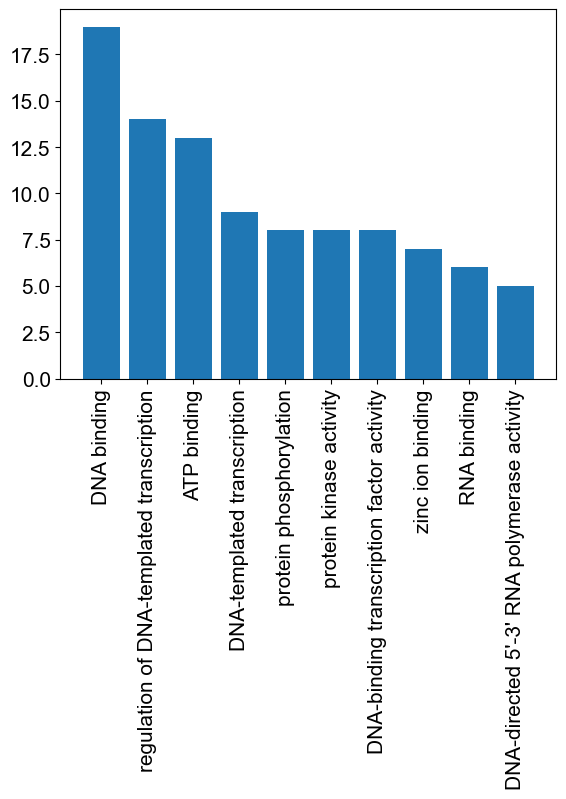

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


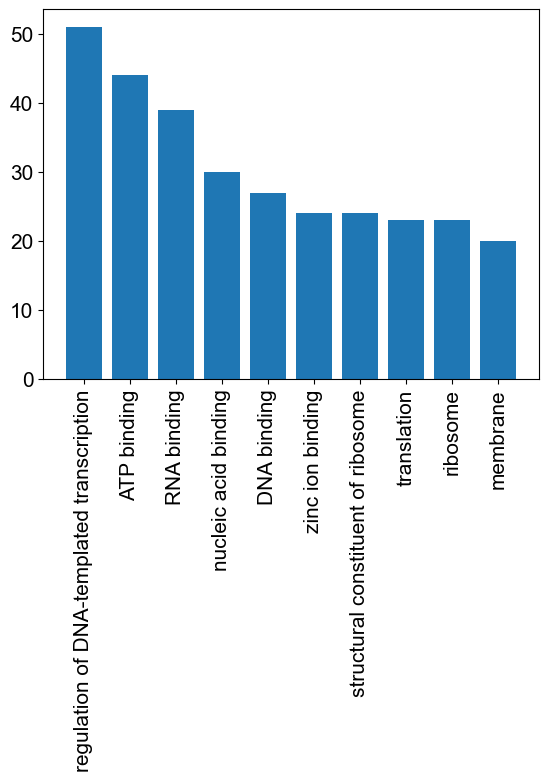

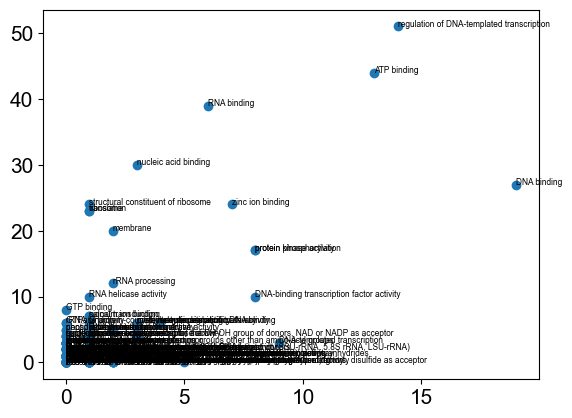

In [77]:
# Read each line of the files, get the GO terms, and compare for the two files

# filename = 'Uniprot_Human/FC_proteins_human.tsv'
filenames = ['Human_Protein_Atlas/Nucleolus_FC_iprscan_results_additional_databases.tsv',
             'Human_Protein_Atlas/Nucleolus_iprscan_results_additional_databases.tsv']
file_types = ['FC', 'Rest']
df_list = []

# Read sequence ID and the corresponding GO terms from the tsv file
for file in filenames:
    df = pd.read_csv(file, delimiter='\t', names=['id', 'GO_terms'], header=None, usecols=[0, 13])
    # Drop those row entries where there are no GO annotations
    df = df[df['GO_terms'] != '-']
    # Remove all proteins that occurred in the previous datasets
    for df_previous in df_list:
        for protein in df['id'].unique():
            if protein in df_previous['id']:
                df = df[df['id']!=protein]
    df_list.append(df)
    
unique_GO_terms_list = []
# Get a histogram of the number of times a particular GO ID occurs in the dataset
for df in df_list:
    unique_GO_terms_list += [go for string in df['GO_terms'] for go in string.split('|')]

unique_GO_terms_list = [go_term.split('(')[0] for go_term in unique_GO_terms]
unique_GO_terms = set(unique_GO_terms_list)        
# print(unique_GO_terms)

go_names_list = []
go_id_list_sorted = []

# Read through the GO OBO file and assign names to the GO terms
store_next_line = 0
with open('go.obo', 'r') as f:
    pattern = re.compile('^id: GO:.*')
    for line in f:
        if store_next_line:
            # Read the name of the GO term
            go_names_list.append(line.rstrip()[6:])
            store_next_line = 0
        if pattern.match(line.rstrip()) and line.rstrip()[4:] in unique_GO_terms:
            go_id_list_sorted.append(line.rstrip()[4:])
            # The next line contains the name of the GO term
            store_next_line = 1
        
go_names_df = pd.DataFrame(data=np.array([go_id_list_sorted, go_names_list]).transpose(), columns=['go_id', 'go_name'])
# go_names_df.head(20)

# print(df_list[0].head(20))
# print(df_list[1].head(20))

for i in range(len(df_list)): # df in df_list:
    # Count the number of occurences of each GO term in each dataset
    go_names_df[file_types[i]] = np.zeros(len(go_names_list))
    # Dataframe to store counts of the different GO terms. Initialize this:
    # counts_df['go_term'] = list(unique_GO_terms)
    # counts_df['counts'] = np.zeros(len(unique_GO_terms))
    for protein in df_list[i]['id'].unique():
        go_terms_for_this_protein = [go for string in list(df_list[i][df_list[i]['id']==protein]['GO_terms']) 
                                     for go in string.split('|')]
        go_terms_for_this_protein = [go.split('(')[0] for go in go_terms_for_this_protein]
        for go_term in go_id_list_sorted:
            if go_term in go_terms_for_this_protein:
                go_names_df[file_types[i]][go_names_df['go_id']==go_term] += 1.0

    # print(np.sum(counts_df['counts']))
    go_names_df[file_types[i]][go_names_df['go_name'] == 'nucleus'] = 0
    go_names_df[file_types[i]][go_names_df['go_name'] == 'protein binding'] = 0
    go_names_df = go_names_df.sort_values(by=file_types[i], ascending=False)
    
    plt.bar(go_names_df['go_name'].iloc[0:10], go_names_df[file_types[i]].iloc[0:10])
    plt.xticks(rotation=90)
    plt.show()
    plt.close()
    
plt.scatter(go_names_df['FC'], go_names_df['Rest'])
for (x, y, name) in zip(go_names_df['FC'], go_names_df['Rest'], go_names_df['go_name']):
    plt.text(x, y, name, fontsize=6)
# plt.xlim([0.0, 0.18])
# plt.ylim([0.0, 0.18])
plt.show()
plt.close()

### Structured domains of the proteins

**Result:** Only the fraction of positive charges in the IDRs is significantly different. However, the net charges of the sequences are not that different!

The GO enrichment analysis of FC/DFC proteins with other nucleolar proteins, using the GO enrichment analysis tool at https://geneontology.org/ suggests that this is the case. **In fact, RNA binding is the ONLY statistically significant difference between the two different proteomes!!!!**

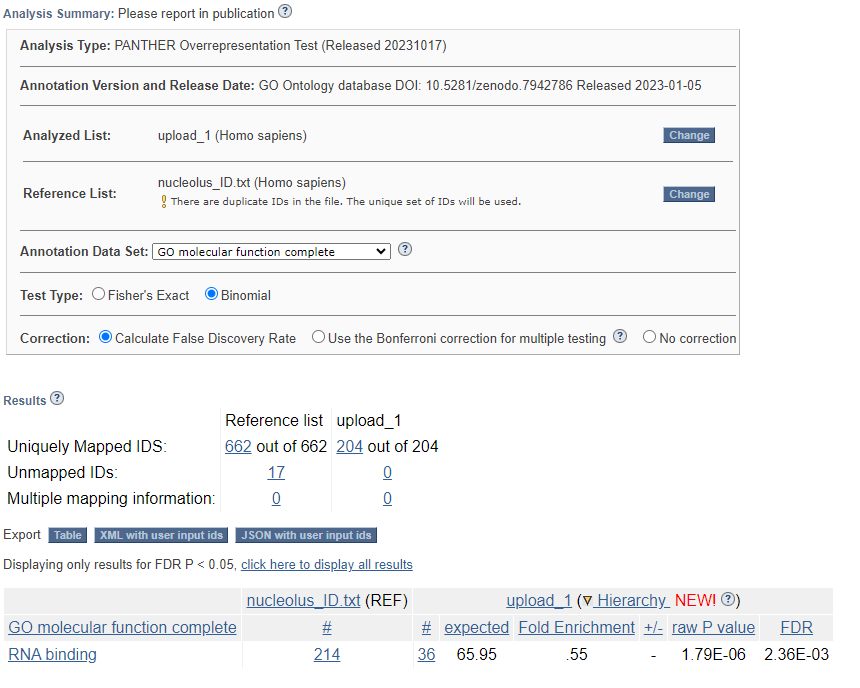

### Plotting the fraction of RNA binding proteins in the FC/DFC vs. rest of the nucleolus

In [ ]:
# Plot histogram of molecular functions of the Fc and other nucleolar proteins

# Show that the RNA binding is the only one that is significantly different from GO enrichment analysis. For this, plot fold enrichment of the different molecular functions, and show that RNA binding is the only one that sticks out. 

fig, axs = plt.subplots(1,1,figsize=(2,4))
fractions = [214.0/662.0, 36.0/204.0]
axs.bar(['GC', 'FC/DFC'], fractions, color='k', width=0.8)
axs.set_ylabel('Fraction of RNA-binding proteins')

## Method 2: Uniprot search with GO terms correponding to FC vs rest of the nucleolus in humans

The GO IDs corresponding the different components of the nucleolus are:
1. **Nucleolar FC:** GO:0001650
2. **Nucleolar DFC:** GO:0001651
3. **Nucleolar GC:** GO:0001652
4. **Nucleolus**: GO:0005730

We searched for all the proteins that corresponded to each of the above GO IDs in humans from Uniprot and stored them in separate files. We only selected those sequences that have been reviewed according SwissProt. For these sequences, we passed them through iprscan5 to get the Pfam domains and regions of disorder as predicted by MobiDBLite.

### IDRs of the proteins excluding domains from Pfam

In [ ]:
# Charge features of proteins

charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Uniprot_Human/FC_proteins_human.fasta',
                                           'Uniprot_Human/Nucleolar_proteins_human.fasta'],
                                          iprscan_file_list=
                                          ['Uniprot_Human/FC_proteins_human.tsv', 
                                           'Uniprot_Human/Nucleolar_proteins_human.tsv'],
                                          names=['FC', 'Rest'])
keys = ['net_charge_per_residue', 'net_charge', 'fraction_positive', 'total_positive',
            'fraction_negative', 'total_negative', 'kappa']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)

**Result:** Only the fraction of positive charges in the IDRs is significantly different. However, the net charges of the sequences are not that different!

In [ ]:
# t-SNE plots to visualize the sequences of the proteins

data_matrix = visualize_tsne(fasta_file_list=['Uniprot_Human/FC_proteins_human.fasta',
                                              'Uniprot_Human/Nucleolar_proteins_human.fasta'],
                             iprscan_file_list=['Uniprot_Human/FC_proteins_human.tsv', 
                                                'Uniprot_Human/Nucleolar_proteins_human.tsv'],
                             names=['FC', 'Rest'])

features = data_matrix.iloc[:, 0:-2]
labels = data_matrix.iloc[:, -1]

# Initialize t-SNE with 2 components (for 2D visualization)
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data
tsne_projection = tsne.fit_transform(features)

# Create a new DataFrame for t-SNE projections
tsne_df = pd.DataFrame(data=tsne_projection, columns=['TSNE1', 'TSNE2'])
tsne_df['Label'] = labels

# Plot t-SNE with color-coded labels
plt.figure(figsize=(6, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_df, palette='coolwarm', legend='full', alpha=1.0)
plt.title('t-SNE Plot')
plt.show()

### IDRs of the proteins excluding domains from Pfam, CDD, Prosite

Number of IDRs from Uniprot_Human/FC_proteins_human_additional_databases.tsv :  125
Number of IDRs from Uniprot_Human/Nucleolar_proteins_human_additional_databases.tsv :  631
Average  Net charge per residue in FC : -0.006707225231257593
Average  Net charge in FC : -0.7374765329386216
Average  Fraction positive in FC : 0.1329850659547436
Average  Positive charge in FC : 14.144
Average  Fraction negative in FC : 0.1430102053362544
Average  Negative charge in FC : 15.2
Average  Kappa in FC : 0.24205912031584315
Average  Net charge per residue in Rest : -0.0067724723878426546
Average  Net charge in Rest : -0.23489589940714073
Average  Fraction positive in Rest : 0.1541500533072119
Average  Positive charge in Rest : 14.553359683794467
Average  Fraction negative in Rest : 0.1637828476654257
Average  Negative charge in Rest : 15.045454545454545
Average  Kappa in Rest : 0.26519988897638885


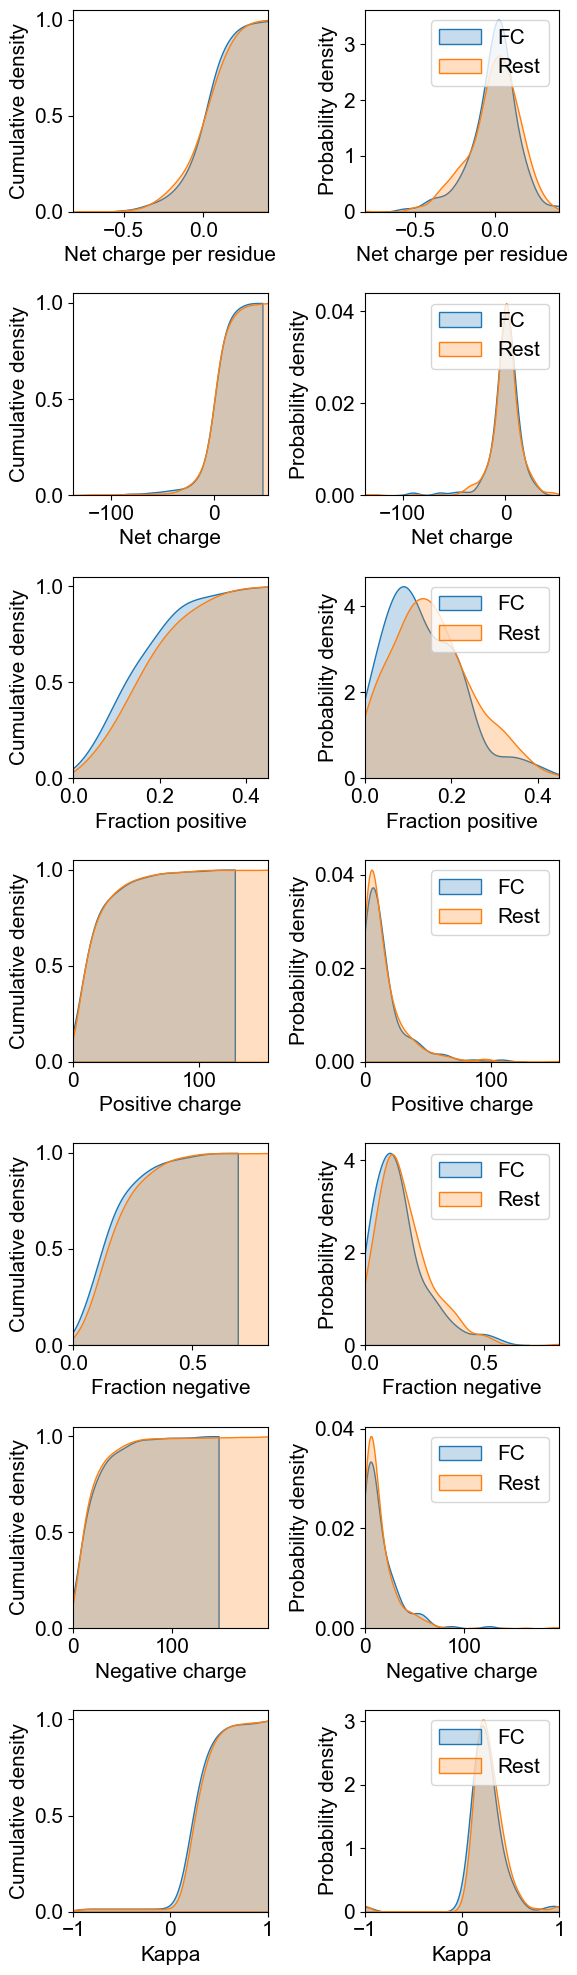

net_charge_per_residue :  KstestResult(statistic=0.10039525691699605, pvalue=0.24456551143190863)
net_charge :  KstestResult(statistic=0.051446640316205536, pvalue=0.9381133593396227)
fraction_positive :  KstestResult(statistic=0.15166798418972333, pvalue=0.017474807814004234)
total_positive :  KstestResult(statistic=0.053059288537549404, pvalue=0.9228358164303756)
fraction_negative :  KstestResult(statistic=0.12137549407114624, pvalue=0.09461522621393481)
total_negative :  KstestResult(statistic=0.0566798418972332, pvalue=0.8822313573528091)
kappa :  KstestResult(statistic=0.11543083003952569, pvalue=0.1262330658965709)


In [161]:
charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Uniprot_Human/FC_proteins_human.fasta',
                                           'Uniprot_Human/Nucleolar_proteins_human.fasta'],
                                          iprscan_file_list=
                                          ['Uniprot_Human/FC_proteins_human_additional_databases.tsv', 
                                           'Uniprot_Human/Nucleolar_proteins_human_additional_databases.tsv'],
                                          names=['FC', 'Rest'])

keys = ['net_charge_per_residue', 'net_charge', 'fraction_positive', 'total_positive',
            'fraction_negative', 'total_negative', 'kappa']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)

### Structured domains

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


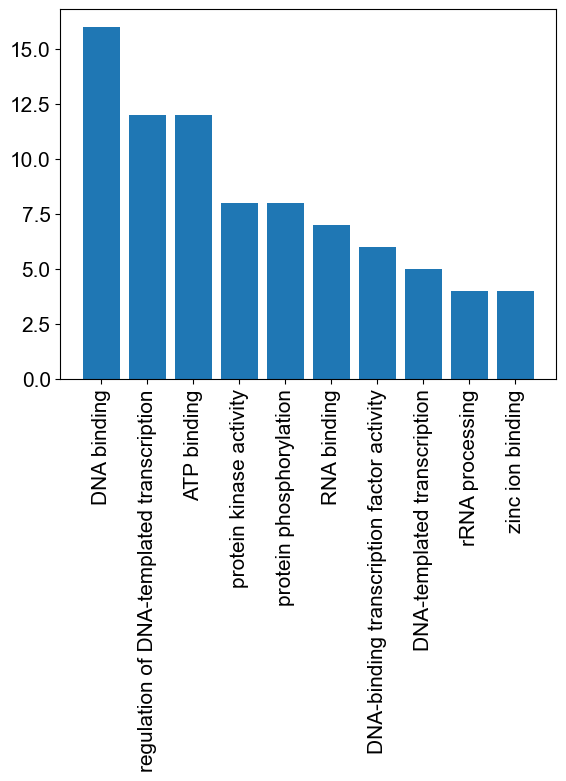

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


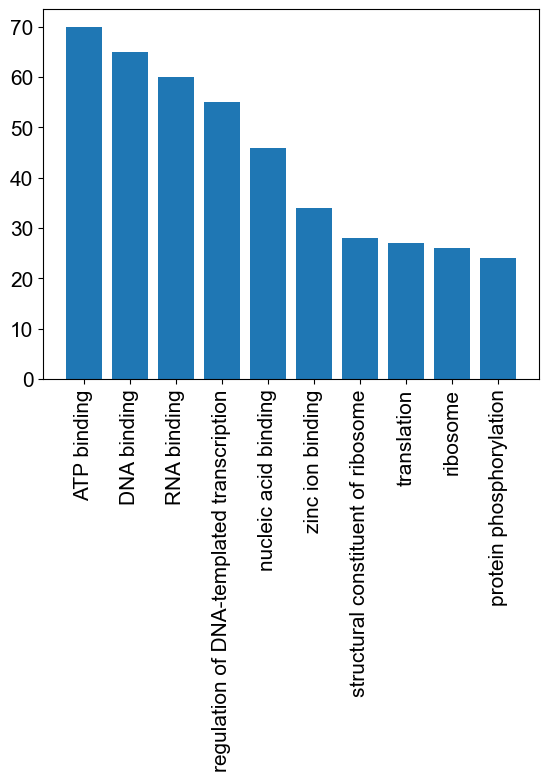

          go_id                                        go_name    FC  Rest  \
28   GO:0003676                           nucleic acid binding   3.0  46.0   
38   GO:0003735             structural constituent of ribosome   1.0  28.0   
135  GO:0006468                        protein phosphorylation   8.0  24.0   
65   GO:0004672                        protein kinase activity   8.0  24.0   
29   GO:0003677                                    DNA binding  16.0  65.0   
131  GO:0006412                                    translation   1.0  27.0   
103  GO:0005840                                       ribosome   1.0  26.0   
34   GO:0003723                                    RNA binding   7.0  60.0   
191  GO:0016570                           histone modification   2.0   2.0   
229  GO:0032958        inositol phosphate biosynthetic process   2.0   2.0   
195  GO:0016593                             Cdc73/Paf1 complex   2.0   2.0   
117  GO:0006351                    DNA-templated transcription  

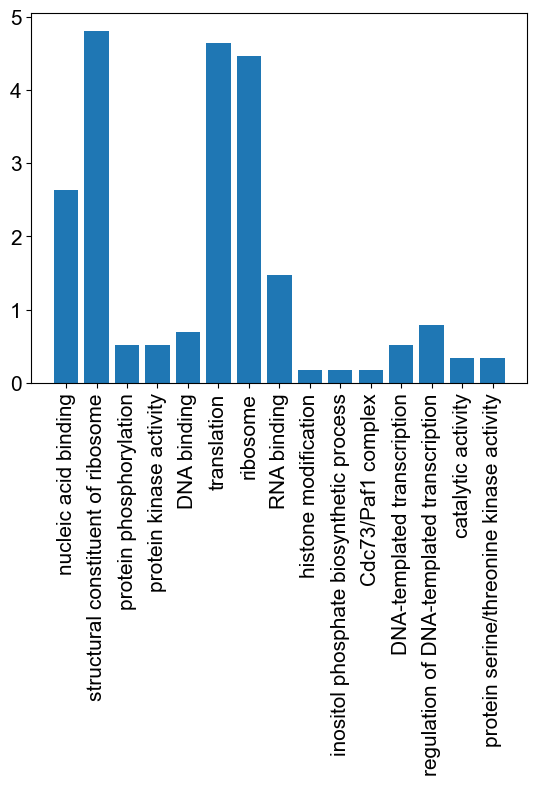

In [148]:
# Read each line of the files, get the GO terms, and compare for the two files

# filename = 'Uniprot_Human/FC_proteins_human.tsv'
filenames = ['Uniprot_Human/FC_proteins_human_additional_databases.tsv', 
             'Uniprot_Human/Nucleolar_proteins_human_additional_databases.tsv']
file_types = ['FC', 'Rest']
df_list = []

# Read sequence ID and the corresponding GO terms from the tsv file
for file in filenames:
    df = pd.read_csv(file, delimiter='\t', names=['id', 'GO_terms'], header=None, usecols=[0, 13])
    # Drop those row entries where there are no GO annotations
    df = df[df['GO_terms'] != '-']
    # Remove all proteins that occurred in the previous datasets
    for df_previous in df_list:
        for protein in df['id'].unique():
            if protein in df_previous['id']:
                drop_indices = df[df['id']==protein].index
                df.drop(drop_indices, inplace=True)
    df_list.append(df)
    
# Get a histogram of the number of times a particular GO ID occurs in the dataset
unique_GO_terms_list = []
for df in df_list:
    unique_GO_terms_list += [go for string in df['GO_terms'] for go in string.split('|')]

unique_GO_terms_list = [go_term.split('(')[0] for go_term in unique_GO_terms]
unique_GO_terms = set(unique_GO_terms_list)        

go_names_list = []
go_id_list_sorted = []

# Read through the GO OBO file and assign names to the GO terms
store_next_line = 0
with open('go.obo', 'r') as f:
    pattern = re.compile('^id: GO:.*')
    for line in f:
        if store_next_line:
            # Read the name of the GO term
            go_names_list.append(line.rstrip()[6:])
            store_next_line = 0
        if pattern.match(line.rstrip()) and line.rstrip()[4:] in unique_GO_terms:
            go_id_list_sorted.append(line.rstrip()[4:])
            # The next line contains the name of the GO term
            store_next_line = 1

            
# Count the number of occurences of each GO term in each dataset (i.e. FC and rest)         
go_names_df = pd.DataFrame(data=np.array([go_id_list_sorted, go_names_list]).transpose(), columns=['go_id', 'go_name'])

for i in range(len(df_list)): # df in df_list:
    # Count the number of occurences of each GO term in each dataset
    go_names_df[file_types[i]] = np.zeros(len(go_names_list))
    # Dataframe to store counts of the different GO terms. Initialize this:
    # counts_df['go_term'] = list(unique_GO_terms)
    # counts_df['counts'] = np.zeros(len(unique_GO_terms))
    for protein in df_list[i]['id'].unique():
        go_terms_for_this_protein = [go for string in list(df_list[i][df_list[i]['id']==protein]['GO_terms']) 
                                     for go in string.split('|')]
        go_terms_for_this_protein = [go.split('(')[0] for go in go_terms_for_this_protein]
        for go_term in go_id_list_sorted:
            if go_term in go_terms_for_this_protein:
                go_names_df[file_types[i]][go_names_df['go_id']==go_term] += 1.0

    # print(np.sum(counts_df['counts']))
    go_names_df[file_types[i]][go_names_df['go_name'] == 'nucleus'] = 0
    go_names_df[file_types[i]][go_names_df['go_name'] == 'protein binding'] = 0
    go_names_df = go_names_df.sort_values(by=file_types[i], ascending=False)
    
    plt.bar(go_names_df['go_name'].iloc[0:10], go_names_df[file_types[i]].iloc[0:10])
    plt.xticks(rotation=90)
    plt.show()
    plt.close()

# Perform Fisher exact test for enrichment analysis
num_fc = len(df_list[0]['id'].unique())
num_rest = len(df_list[1]['id'].unique())

def get_p_value(fc_counts, rest_counts, num_fc_proteins=num_fc, num_rest_proteins=num_rest):
    return (sps.comb(fc_counts + rest_counts, fc_counts)*
            sps.comb(num_fc_proteins - fc_counts + num_rest_proteins - rest_counts, num_fc_proteins - fc_counts)/
            sps.comb(num_fc_proteins + num_rest_proteins, num_fc_proteins))

go_names_df['pvalue'] = go_names_df.apply(lambda x: get_p_value(x.FC, x.Rest), axis=1)

# Calculate enrichment values
go_names_df['enrichment'] = np.divide(go_names_df['Rest'], go_names_df['FC'])*num_fc/num_rest
go_names_df.replace([np.inf, -np.inf], np.nan, inplace=True)
go_names_df.dropna(subset=["enrichment"], how="all", inplace=True)
go_names_df = go_names_df.sort_values(by='pvalue', ascending=True)
print(go_names_df.head(20))
plt.bar(go_names_df['go_name'].iloc[0:15], go_names_df['enrichment'].iloc[0:15])
plt.xticks(rotation=90)
plt.show()
plt.close()

# p = np.divide(go_names_df['Rest'], num_rest)
# plt.scatter(np.divide(go_names_df['Rest'], num_rest), np.divide(go_names_df['FC'], num_fc))
# plt.plot(p, p + 1.96*np.sqrt(p*(1.0-p)/num_fc), ':k')
# plt.plot(p, p - 1.96*np.sqrt(p*(1.0-p)/num_fc), ':k')
# # plt.plot(np.divide(go_names_df['Rest'], num_rest), p - 1.96*p*(1.0-p), '--k')
# plt.plot(p, p, '-k')
# for (x, y, name) in zip(np.divide(go_names_df['Rest'], num_rest), 
#                         np.divide(go_names_df['FC'], num_fc),
#                         go_names_df['go_name']):
#     plt.text(x, y, name, fontsize=10)
# plt.xlim([0.0, 0.18])
# plt.ylim([0.0, 0.18])
# plt.legend()
# plt.show()
# plt.close()

## Method 3: FC and nucleolar proteins in mouse from Uniprot according the GO terms

The GO IDs corresponding the different components of the nucleolus are:
1. **Nucleolar FC:** GO:0001650
2. **Nucleolus**: GO:0005730

We searched for all the proteins that corresponded to each of the above GO IDs in mouse from Uniprot and stored them in separate files. For the first category, we collected all the proteins that fall in this category. For the second category i.e. the nucleolus, we gathered all proteins that have GO ID 0005730 but NOT 0001650. For these sequences, we passed them through iprscan5 to get the Pfam domains and regions of disorder as predicted by MobiDBLite.

### IDRS of proteins excluding Pfam domains, CDD, and Prosite

Number of IDRs from Uniprot_Mouse/FC_proteins_mouse_additional_databases.tsv :  147
Number of IDRs from Uniprot_Mouse/Nucleolar_proteins_mouse_additional_databases.tsv :  675
Average  Net charge per residue in FC : -0.015161830099048753
Average  Net charge in FC : -1.485202130986374
Average  Fraction positive in FC : 0.13145448518866354
Average  Positive charge in FC : 13.843537414965986
Average  Fraction negative in FC : 0.1495546177126096
Average  Negative charge in FC : 15.646258503401361
Average  Kappa in FC : 0.26761128349941354
Average  Net charge per residue in Rest : -0.005593226749633213
Average  Net charge in Rest : -0.8563753869177685
Average  Fraction positive in Rest : 0.15425018446275135
Average  Positive charge in Rest : 14.687407407407408
Average  Fraction negative in Rest : 0.16258996714722956
Average  Negative charge in Rest : 15.792592592592593
Average  Kappa in Rest : 0.24883607493859075


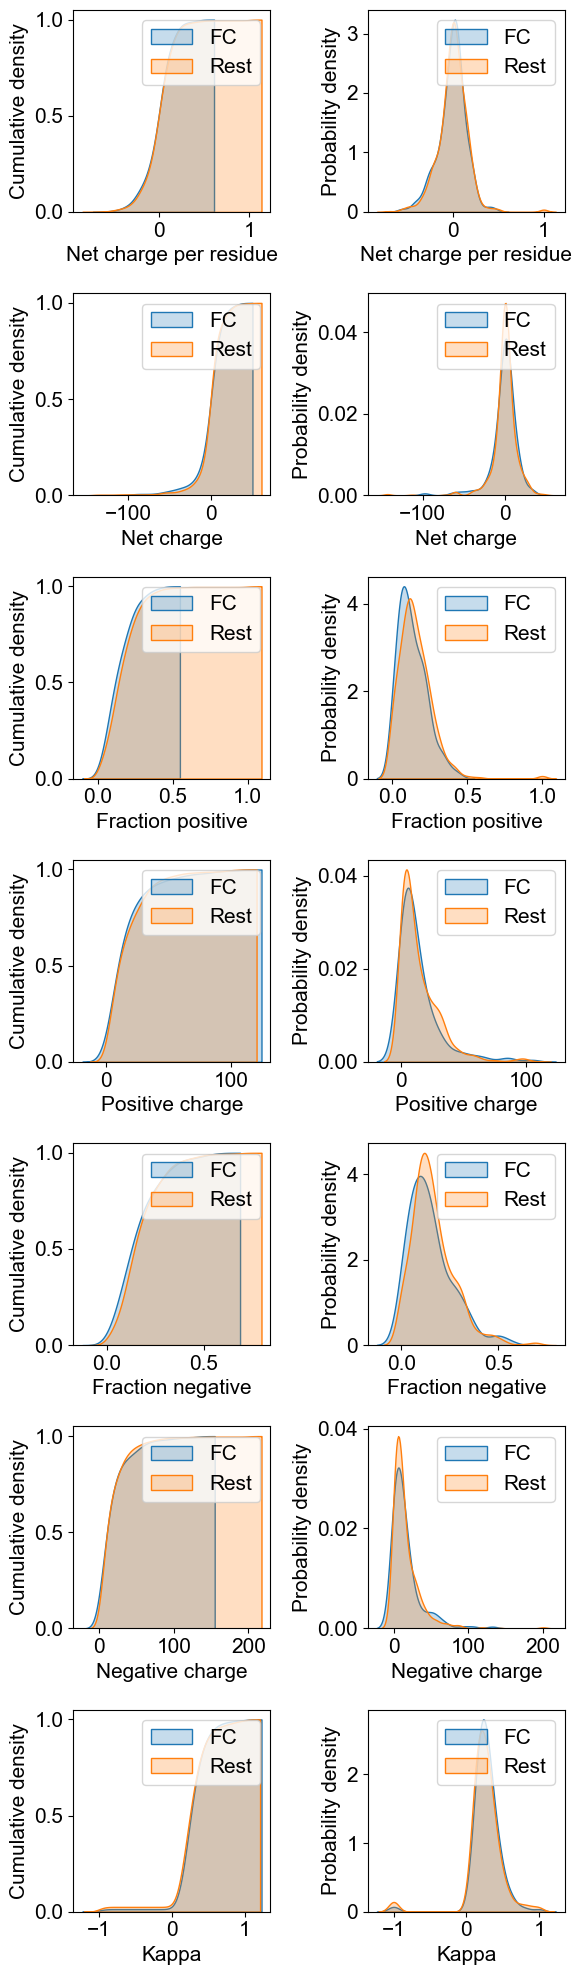

net_charge_per_residue :  KstestResult(statistic=0.07020408163265306, pvalue=0.5635327632586438)
net_charge :  KstestResult(statistic=0.04559334845049131, pvalue=0.9516947520853464)
fraction_positive :  KstestResult(statistic=0.12311413454270598, pvalue=0.04668915964459641)
total_positive :  KstestResult(statistic=0.07362055933484504, pvalue=0.5028620056098675)
fraction_negative :  KstestResult(statistic=0.11171579743008314, pvalue=0.09006414914798477)
total_negative :  KstestResult(statistic=0.08786092214663643, pvalue=0.2893399591626151)
kappa :  KstestResult(statistic=0.10790627362055934, pvalue=0.1105978402251162)


In [88]:
# Charge features of proteins

charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Uniprot_Mouse/FC_proteins_mouse.fasta',
                                           'Uniprot_Mouse/Nucleolar_proteins_mouse.fasta'],
                                          iprscan_file_list=
                                          ['Uniprot_Mouse/FC_proteins_mouse_additional_databases.tsv', 
                                           'Uniprot_Mouse/Nucleolar_proteins_mouse_additional_databases.tsv'],
                                          names=['FC', 'Rest'])
keys = ['net_charge_per_residue', 'net_charge', 'fraction_positive', 'total_positive',
            'fraction_negative', 'total_negative', 'kappa']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


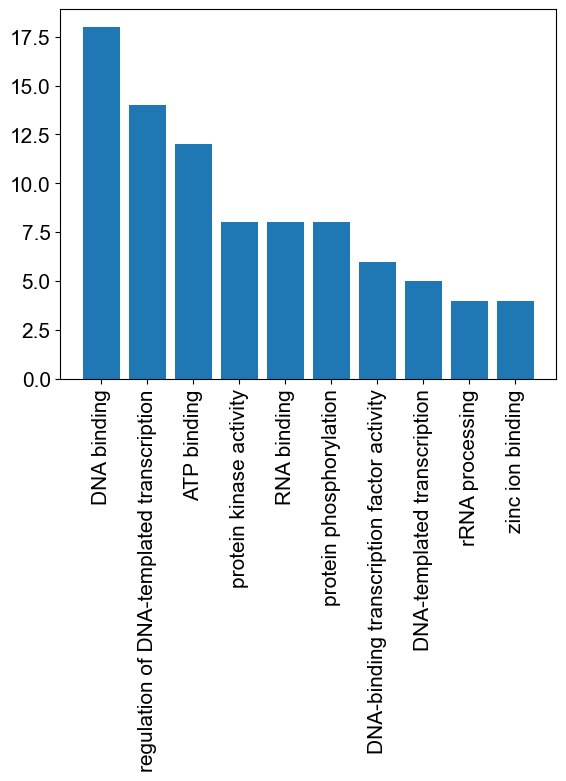

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


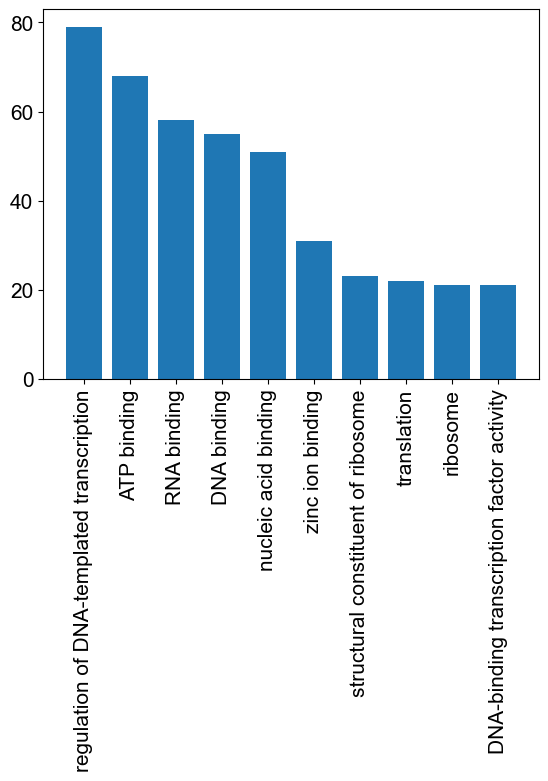

          go_id                                        go_name    FC  Rest  \
28   GO:0003676                           nucleic acid binding   2.0  51.0   
29   GO:0003677                                    DNA binding  18.0  55.0   
178  GO:0008430                               selenium binding   2.0   0.0   
229  GO:0032958        inositol phosphate biosynthetic process   2.0   0.0   
191  GO:0016570                           histone modification   2.0   0.0   
195  GO:0016593                             Cdc73/Paf1 complex   2.0   0.0   
65   GO:0004672                        protein kinase activity   8.0  17.0   
135  GO:0006468                        protein phosphorylation   8.0  17.0   
44   GO:0003824                             catalytic activity   3.0   3.0   
66   GO:0004674       protein serine/threonine kinase activity   3.0   3.0   
38   GO:0003735             structural constituent of ribosome   1.0  23.0   
117  GO:0006351                    DNA-templated transcription  

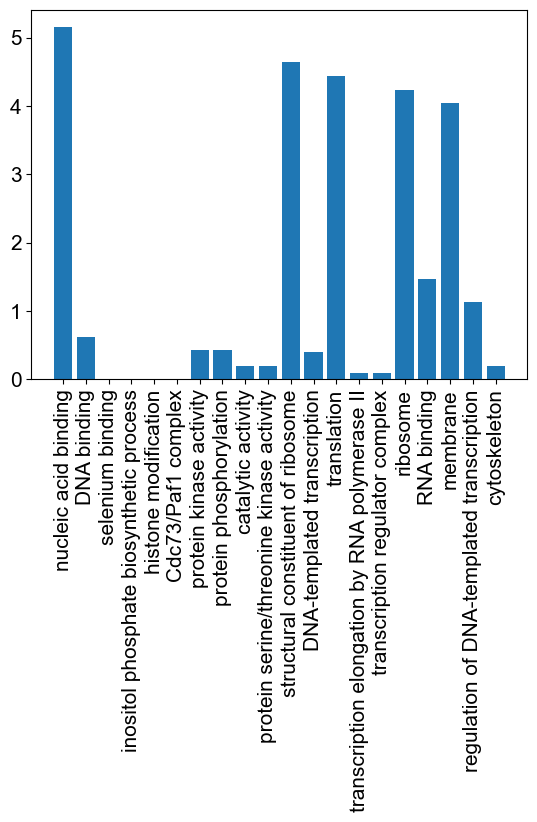

In [150]:
# Read each line of the files, get the GO terms, and compare for the two files

# filename = 'Uniprot_Human/FC_proteins_human.tsv'
filenames = ['Uniprot_Mouse/FC_proteins_mouse_additional_databases.tsv', 
             'Uniprot_Mouse/Nucleolar_proteins_mouse_additional_databases.tsv']
file_types = ['FC', 'Rest']
df_list = []

# Read sequence ID and the corresponding GO terms from the tsv file
for file in filenames:
    df = pd.read_csv(file, delimiter='\t', names=['id', 'GO_terms'], header=None, usecols=[0, 13])
    # Drop those row entries where there are no GO annotations
    df = df[df['GO_terms'] != '-']
    # Remove all proteins that occurred in the previous datasets
    for df_previous in df_list:
        for protein in df['id'].unique():
            if protein in df_previous['id']:
                drop_indices = df[df['id']==protein].index
                df.drop(drop_indices, inplace=True)
    df_list.append(df)
    
# Get a histogram of the number of times a particular GO ID occurs in the dataset
unique_GO_terms_list = []
for df in df_list:
    unique_GO_terms_list += [go for string in df['GO_terms'] for go in string.split('|')]

unique_GO_terms_list = [go_term.split('(')[0] for go_term in unique_GO_terms]
unique_GO_terms = set(unique_GO_terms_list)        

go_names_list = []
go_id_list_sorted = []

# Read through the GO OBO file and assign names to the GO terms
store_next_line = 0
with open('go.obo', 'r') as f:
    pattern = re.compile('^id: GO:.*')
    for line in f:
        if store_next_line:
            # Read the name of the GO term
            go_names_list.append(line.rstrip()[6:])
            store_next_line = 0
        if pattern.match(line.rstrip()) and line.rstrip()[4:] in unique_GO_terms:
            go_id_list_sorted.append(line.rstrip()[4:])
            # The next line contains the name of the GO term
            store_next_line = 1

            
# Count the number of occurences of each GO term in each dataset (i.e. FC and rest)         
go_names_df = pd.DataFrame(data=np.array([go_id_list_sorted, go_names_list]).transpose(), columns=['go_id', 'go_name'])

for i in range(len(df_list)): # df in df_list:
    # Count the number of occurences of each GO term in each dataset
    go_names_df[file_types[i]] = np.zeros(len(go_names_list))
    # Dataframe to store counts of the different GO terms. Initialize this:
    # counts_df['go_term'] = list(unique_GO_terms)
    # counts_df['counts'] = np.zeros(len(unique_GO_terms))
    for protein in df_list[i]['id'].unique():
        go_terms_for_this_protein = [go for string in list(df_list[i][df_list[i]['id']==protein]['GO_terms']) 
                                     for go in string.split('|')]
        go_terms_for_this_protein = [go.split('(')[0] for go in go_terms_for_this_protein]
        for go_term in go_id_list_sorted:
            if go_term in go_terms_for_this_protein:
                go_names_df[file_types[i]][go_names_df['go_id']==go_term] += 1.0

    # print(np.sum(counts_df['counts']))
    go_names_df[file_types[i]][go_names_df['go_name'] == 'nucleus'] = 0
    go_names_df[file_types[i]][go_names_df['go_name'] == 'protein binding'] = 0
    go_names_df = go_names_df.sort_values(by=file_types[i], ascending=False)
    
    plt.bar(go_names_df['go_name'].iloc[0:10], go_names_df[file_types[i]].iloc[0:10])
    plt.xticks(rotation=90)
    plt.show()
    plt.close()

# Perform Fisher exact test for enrichment analysis
num_fc = len(df_list[0]['id'].unique())
num_rest = len(df_list[1]['id'].unique())

def get_p_value(fc_counts, rest_counts, num_fc_proteins=num_fc, num_rest_proteins=num_rest):
    return (sps.comb(fc_counts + rest_counts, fc_counts)*
            sps.comb(num_fc_proteins - fc_counts + num_rest_proteins - rest_counts, num_fc_proteins - fc_counts)/
            sps.comb(num_fc_proteins + num_rest_proteins, num_fc_proteins))

go_names_df['pvalue'] = go_names_df.apply(lambda x: get_p_value(x.FC, x.Rest), axis=1)

# Calculate enrichment values
go_names_df['enrichment'] = np.divide(go_names_df['Rest'], go_names_df['FC'])*num_fc/num_rest
go_names_df.replace([np.inf, -np.inf], np.nan, inplace=True)
go_names_df.dropna(subset=["enrichment"], how="all", inplace=True)
go_names_df = go_names_df.sort_values(by='pvalue', ascending=True)
print(go_names_df.head(20))
plt.bar(go_names_df['go_name'].iloc[0:20], go_names_df['enrichment'].iloc[0:20])
plt.xticks(rotation=90)
plt.show()
plt.close()

# p = np.divide(go_names_df['Rest'], num_rest)
# plt.scatter(np.divide(go_names_df['Rest'], num_rest), np.divide(go_names_df['FC'], num_fc))
# plt.plot(p, p + 1.96*np.sqrt(p*(1.0-p)/num_fc), ':k')
# plt.plot(p, p - 1.96*np.sqrt(p*(1.0-p)/num_fc), ':k')
# # plt.plot(np.divide(go_names_df['Rest'], num_rest), p - 1.96*p*(1.0-p), '--k')
# plt.plot(p, p, '-k')
# for (x, y, name) in zip(np.divide(go_names_df['Rest'], num_rest), 
#                         np.divide(go_names_df['FC'], num_fc),
#                         go_names_df['go_name']):
#     plt.text(x, y, name, fontsize=10)
# plt.xlim([0.0, 0.18])
# plt.ylim([0.0, 0.18])
# plt.legend()
# plt.show()
# plt.close()

## Method 4: Identify the FC and nucleolar proteins that have the most impact on the shape of the nulceolus upon inhibition

I tabulated the proteins that have themost impact on nucleolar shape upon inhibition, based on figure 2 of this paper: https://www.nature.com/articles/s41596-018-0044-3

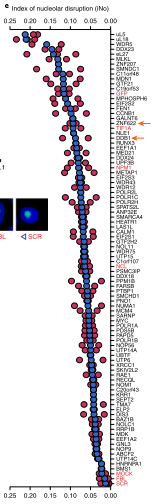

I then processed this list further as described below:

1. Some of the proteins are essential proteins for the cell, not necessarily present in the nucleolus. These proteins were excluded. 
2. After removing these proteins, I categorized the remaining proteins into those that are present in FC and those that are present in the rest of the nucleolus. I made similar lists for humans and mice. 

In [ ]:
charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Nucleolar_Structural_Proteins/Human_FC_proteins.fasta',
                                           'Nucleolar_Structural_Proteins/Human_nucleolar_proteins.fasta'],
                                          iprscan_file_list=
                                          ['Nucleolar_Structural_Proteins/Human_FC_proteins.tsv', 
                                           'Nucleolar_Structural_Proteins/Human_nucleolar_proteins.tsv'],
                                          names=['FC', 'Rest'])

keys = ['net_charge_per_residue', 'net_charge', 'fraction_positive', 'total_positive',
            'fraction_negative', 'total_negative', 'kappa']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)

## Method 5: Find all the interacting partners of UBTF

We found all the interacting partners of the human UBTF protein from the database BioGrid, and then passed them through the usual pipeline of predicting IDRs and filtering those that overlap with structured domains. 

In [ ]:
charge_features_dict_list = analyze_files(fasta_file_list=
                                          ['Biogrid_UBTF_interactors/UBTF_interacting_proteins.fasta',
                                           'Biogrid_UBTF_interactors/Nucleolar_proteins_human.fasta'],
                                          iprscan_file_list=
                                          ['Biogrid_UBTF_interactors/UBTF_interacting_proteins.tsv', 
                                           'Biogrid_UBTF_interactors/Nucleolar_proteins_human.tsv'],
                                          names=['FC', 'Rest of nucleolus'])
keys = ['net_charge_per_residue', 'net_charge', 'fraction_positive', 'total_positive',
            'fraction_negative', 'total_negative', 'kappa']

for key in keys:
    results = ks_2samp(charge_features_dict_list[0][key], charge_features_dict_list[1][key])
    print(key, ': ', results)